In [2]:
%matplotlib inline
import d2ltorch as d2lt
import torch
from torch import autograd, nn, optim
from torch.utils import data as tdata
import numpy as np
import pandas as pd

In [3]:
train_data = pd.read_csv('../house_prices/train.csv')
test_data = pd.read_csv('../house_prices/test.csv')

测试集包括1459个样本和80个特征，需要预测出1459个样本的标签

In [4]:
#train_data.shape
test_data.shape

(1459, 80)

In [5]:
train_data.iloc[0:5,[0,1,2,3,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SalePrice
0,1,60,RL,65.0,208500
1,2,20,RL,80.0,181500
2,3,60,RL,68.0,223500
3,4,70,RL,60.0,140000
4,5,60,RL,84.0,250000


ID明显和房价无关，去掉此特征

## 相同字段的表首尾相接
### 现将表构成list，然后在作为concat的输入
In [4]: frames = [df1, df2, df3]
  
In [5]: result = pd.concat(frames)

In [6]:
frame=[train_data.iloc[:,1:-1],test_data.iloc[:,1:]]
all_features=pd.concat(frame)

In [7]:
#成功去掉ID
all_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


# 数据预处理

## 标准化

In [8]:
#numeric=all_features.dtypes!='object'#找出数值型特征
#numeric..index('True')
#取出数值型特征
#all_features[numeric.index].index
#all_features[numeric.index]=all_features[numeric.index].apply(lambda x:(x-x.mean())/(x.std()))

numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))                                                          

In [9]:
#标准化后均值均为0，用0填补缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

## 数值型特征现在长这样

In [10]:
all_features[numeric_features]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0.348780,-0.740634,0.199972,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,0.157619
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,-0.059772,1.614603,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.446848,-0.602858
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0.627338,-0.740634,-0.081195,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,1.026577,0.157619
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0.785188,-0.740634,-0.184783,3.874303,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,-1.363335
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,1.685860,0.776834,0.540332,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,2.131647,0.157619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,-2.195385,-0.740634,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.078492,-1.363335
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,-0.867591,-0.740634,-0.347564,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.815205,-1.363335
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0.478774,3.005615,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,1.026577,-1.363335
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,-2.195385,-0.108355,-0.229178,-0.359539,-0.103313,-0.285886,-0.063139,1.144116,0.289865,-1.363335


## data_expression描述中可以看到有许多特征值是离散的
## 下一步将离散数值转换为指示特征
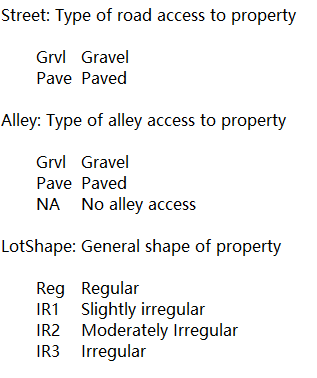

## 特征维数增加到331维

In [11]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [12]:
#转换成tensor
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[: n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train: ].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).reshape(-1, 1)

## 线性回归在神经网络图中表示为单层神经网络，线性回归输出层中的神经元和输入层中各个输入完全连接。因此，线性回归的输出层又叫全连接层。在nn（神经元）中，全连接层是一个Linear实例。该层输入特征数为331，输出个数为1

In [13]:
def get_net():
    return nn.Sequential(nn.Linear(331, 1))

## 定义一个模型变量net，它是一个Sequential实例。在nn中，Sequential实例可以看作是一个串联各个层的容器。在构造模型时在该容器中依次添加层。

## 定义损失函数

In [14]:
loss = nn.MSELoss() # 均方损失等于平方损失除以样本数，PyTorch中，nn模块定义了各种损失函数

def log_rmse(net, features, labels):
    # 将小于1的值设成1，使得取对数时数值更稳定,clamp函数限制张量范围
    clipped_preds = torch.clamp(net(features), min=1)
    rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse

## 对数均方根误差。给定预测值$\hat y_1, \ldots, \hat y_n$和对应的真实标签$y_1,\ldots, y_n$，它的定义为

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log(y_i)-\log(\hat y_i)\right)^2}.$$

In [15]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):#weight_decay权重衰减解决过拟合，小批量梯度下降算法
    train_ls, test_ls = [], []
    #加载小批量数据
    train_iter = tdata.DataLoader(tdata.TensorDataset(
        train_features, train_labels), batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, 
                           weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()#反向传播求梯度
            optimizer.step()#更新权重参数和偏差
        with torch.no_grad():
            train_ls.append(log_rmse(net, train_features, train_labels))#求解对数均方根误差
            if test_labels is not None:
                test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### Batch size：一次放入模型训练的样本数；Iteration：表示1次迭代（也叫training step），1个iteration等于使用batch size个样本训练一次，每次迭代更新1次网络结构的参数。Epoch：1个epoch等于使用训练集中的全部样本训练一次。一般来说，Epoch = Batch size * Iteration

## 模型选择：k折交叉验证

In [56]:
import matplotlib.pyplot as plt

In [16]:
def get_k_fold_data(k, i, X, y):#一个子数据集验证模型，并使用其他K−1个子数据集来训练模型
    assert k > 1
    fold_size = X.shape[0] // k
    x_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif x_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], dim=0)
            y_train = torch.cat([y_train, y_part], dim=0)
    return X_train, y_train, X_valid, y_valid

In [62]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        #fixk=0
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        fixk=i
        if i == 0:
            d2lt.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
            #plt.title("k=",fixk)
        print('fold %d, train rmse %f, valid rmse %f'
              % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k#对这K次训练误差和验证误差分别求平均

## 解决过拟合：权重衰减等价于L2范数正则化，在模型原损失函数基础上添加模型权重参数每个元素的平方和与一个正的常数的乘积

fold 0, train rmse 0.371422, valid rmse 0.388096
fold 1, train rmse 0.370842, valid rmse 0.389922
fold 2, train rmse 0.381958, valid rmse 0.370383
3-fold validation: avg train rmse 0.374741, avg valid rmse 0.382800


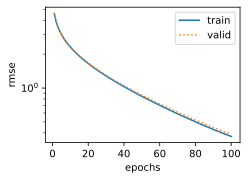

In [76]:
k, num_epochs, lr, weight_decay, batch_size = 3, 100, 5, 2, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f'% (k, train_l, valid_l))

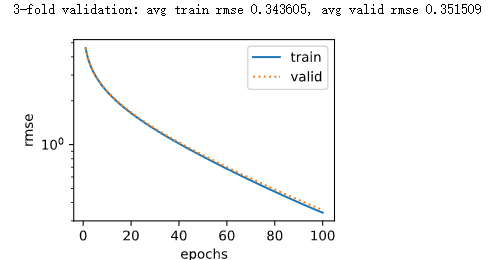

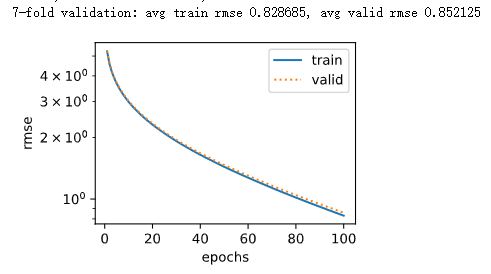

## k越大，rmse越大

In [71]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2lt.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    with torch.no_grad():
        preds = net(test_features).numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train rmse 0.344229


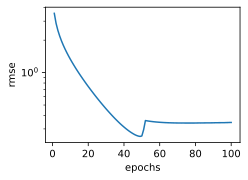

In [77]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

In [78]:
predict_Price = pd.read_csv('../deepLearning/submission.csv')
predict_Price.iloc[0:5,:]
#predict_Price.iloc[-5:-1,:]

,Id,SalePrice
0,1461,118768.08
1,1462,157404.47
2,1463,195758.69
3,1464,214966.22
4,1465,171829.66
